In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geemap
!pip install geopandas
!pip install rasterio
!pip install rasterio geopandas scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.2 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import rasterio
import ee
import geemap
import os
# Import necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [4]:
import rasterio
import numpy as np

def load_and_normalize_image(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        img = np.nan_to_num(img, nan=0.0)  # Replace NaN values with 0
        img = img.astype('float32')

        # Min-max normalization for each band
        for i in range(img.shape[0]):
            band_min = img[i].min()
            band_max = img[i].max()
            img[i] = (img[i] - band_min) / (band_max - band_min)

        transform = src.transform
        crs = src.crs
    return img, transform, crs

# Load and normalize the 2017 image
img_2017, transform_2017, crs_2017 = load_and_normalize_image('/content/drive/My Drive/EarthEngine/Sentinel2_2017.tif')
print(f"2017 Image: min={np.min(img_2017)}, max={np.max(img_2017)}, mean={np.mean(img_2017)}")

# Load and normalize the 2024 image
img_2024, transform_2024, crs_2024 = load_and_normalize_image('/content/drive/My Drive/EarthEngine/Sentinel2_2024.tif')
print(f"2024 Image: min={np.min(img_2024)}, max={np.max(img_2024)}, mean={np.mean(img_2024)}")
# Path to the labeled shapefile
geopackage_path = '/content/drive/MyDrive/EO/ROI/ROI2.gpkg'

# Read the labeled GeoPackage file
labeled_gdf = gpd.read_file(geopackage_path)

# Ensure the GeoDataFrame is in the correct projection (WGS84)
labeled_gdf = labeled_gdf.to_crs(epsg=4326)

# Filter out rows with None or empty geometries
labeled_gdf = labeled_gdf[~labeled_gdf.is_empty]

# Display the first few rows to check the data
print(labeled_gdf[labeled_gdf['id'].isnull()])

2017 Image: min=0.0, max=1.0, mean=0.10090185701847076
2024 Image: min=0.0, max=1.0, mean=0.13437217473983765
Empty GeoDataFrame
Columns: [id, geometry]
Index: []


In [5]:

# Function to ensure geometries are valid and have the correct CRS
def preprocess_geometries(labeled_gdf, target_crs):
    labeled_gdf = labeled_gdf[labeled_gdf['geometry'].notnull()]
    labeled_gdf = labeled_gdf[labeled_gdf.is_valid]
    if labeled_gdf.crs != target_crs:
        labeled_gdf = labeled_gdf.to_crs(target_crs)
    return labeled_gdf

# Function to extract training data
def extract_training_data(image, labeled_gdf, transform, num_samples_per_class=500):
    X = []
    y = []
    for index, row in labeled_gdf.iterrows():
        geom = [row['geometry']]  # Geometry must be a sequence
        label = row['id']  # Adjust the column name to reflect your label column

        # Create a mask for the polygon
        mask = rasterio.features.geometry_mask(geom, transform=transform, invert=True, out_shape=(image.shape[1], image.shape[2]))

        # Extract pixel values within the polygon
        pixels = np.column_stack([np.ma.masked_array(image[band], mask=~mask).compressed() for band in range(image.shape[0])])

        # Randomly sample a subset of pixels if there are too many
        #if pixels.shape[0] > num_samples_per_class:
        #    indices = np.random.choice(pixels.shape[0], num_samples_per_class, replace=False)
        #    pixels = pixels[indices]

        X.extend(pixels)
        y.extend([label] * pixels.shape[0])

    return np.array(X), np.array(y)

# Preprocess geometries
#target_crs = rasterio.open('/content/drive/My Drive/EarthEngine/Sentinel2_2024.tif').crs
#labeled_gdf = preprocess_geometries(labeled_gdf, target_crs)



Training data shape: (36861, 10)
Training labels shape: (36861,)
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2824
           2       1.00      1.00      1.00      3438
           3       0.99      0.99      0.99      1876
           4       0.97      0.97      0.97      1828
           5       0.95      0.96      0.95      1093

    accuracy                           0.99     11059
   macro avg       0.98      0.98      0.98     11059
weighted avg       0.99      0.99      0.99     11059



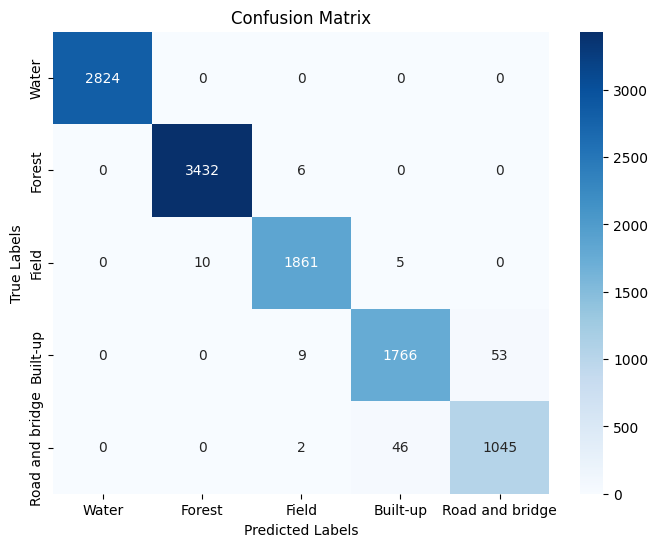

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Extract training data from the 2017 image
X_train, y_train = extract_training_data(img_2017, labeled_gdf, transform_2017)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

# Split the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf2017 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2017.fit(X_train_split, y_train_split)

# Evaluate the classifier
y_pred_split = clf2017.predict(X_test_split)
print(classification_report(y_test_split, y_pred_split))
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_split, y_pred_split)
custom_labels = ['Water', 'Forest', 'Field', 'Built-up', 'Road and bridge']  # {1:'not_dune', 2:'dune'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Training data shape: (36861, 10)
Training labels shape: (36861,)
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2824
           2       0.99      1.00      0.99      3438
           3       0.99      0.98      0.98      1876
           4       0.98      0.96      0.97      1828
           5       0.94      0.98      0.96      1093

    accuracy                           0.99     11059
   macro avg       0.98      0.98      0.98     11059
weighted avg       0.99      0.99      0.99     11059



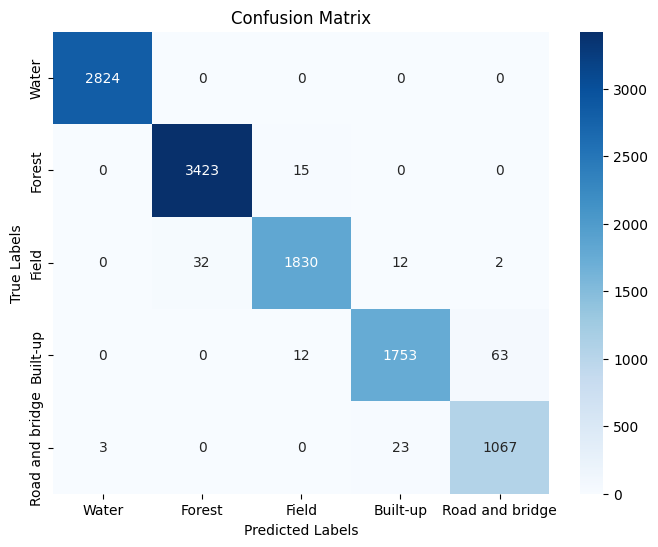

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Extract training data from the 2024 image
X_train, y_train = extract_training_data(img_2024, labeled_gdf, transform_2024)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

# Split the data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf2024 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2024.fit(X_train_split, y_train_split)

# Evaluate the classifier
y_pred_split = clf2024.predict(X_test_split)
print(classification_report(y_test_split, y_pred_split))
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_split, y_pred_split)
custom_labels = ['Water', 'Forest', 'Field', 'Built-up', 'Road and bridge']  # {1:'not_dune', 2:'dune'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_labels,
            yticklabels=custom_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Reshape the 2017 image data to (n_samples, n_features)
n_samples = img_2017.shape[1] * img_2017.shape[2]
X_2017 = img_2017.reshape((img_2017.shape[0], n_samples)).T

# Predict the land cover and land use for 2017
y_pred_2017 = clf2017.predict(X_2017)

# Reshape the predictions back to the original image shape
y_pred_2017_img = y_pred_2017.reshape((img_2017.shape[1], img_2017.shape[2]))

# Save the classification result as a new GeoTIFF
with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2017_LCLU.tif', 'w', driver='GTiff',
                   height=img_2017.shape[1], width=img_2017.shape[2], count=1, dtype=y_pred_2017_img.dtype,
                   crs=crs_2017, transform=transform_2017) as dst:
    dst.write(y_pred_2017_img, 1)

In [9]:
# Reshape the 2024 image data to (n_samples, n_features)
n_samples = img_2024.shape[1] * img_2024.shape[2]
X_2024 = img_2024.reshape((img_2024.shape[0], n_samples)).T
#X_2024 = np.nan_to_num(X_2024, nan=0.0)

# Predict the land cover and land use for 2024
y_pred_2024 = clf2024.predict(X_2024)

# Reshape the predictions back to the original image shape
y_pred_2024_img = y_pred_2024.reshape((img_2024.shape[1], img_2024.shape[2]))

# Save the classification result as a new GeoTIFF
with rasterio.open('/content/drive/My Drive/EarthEngine/RF_2024_LCLU.tif', 'w', driver='GTiff',
                   height=img_2024.shape[1], width=img_2024.shape[2], count=1, dtype=y_pred_2024_img.dtype,
                   crs=crs_2017, transform=transform_2024) as dst:
    dst.write(y_pred_2024_img, 1)


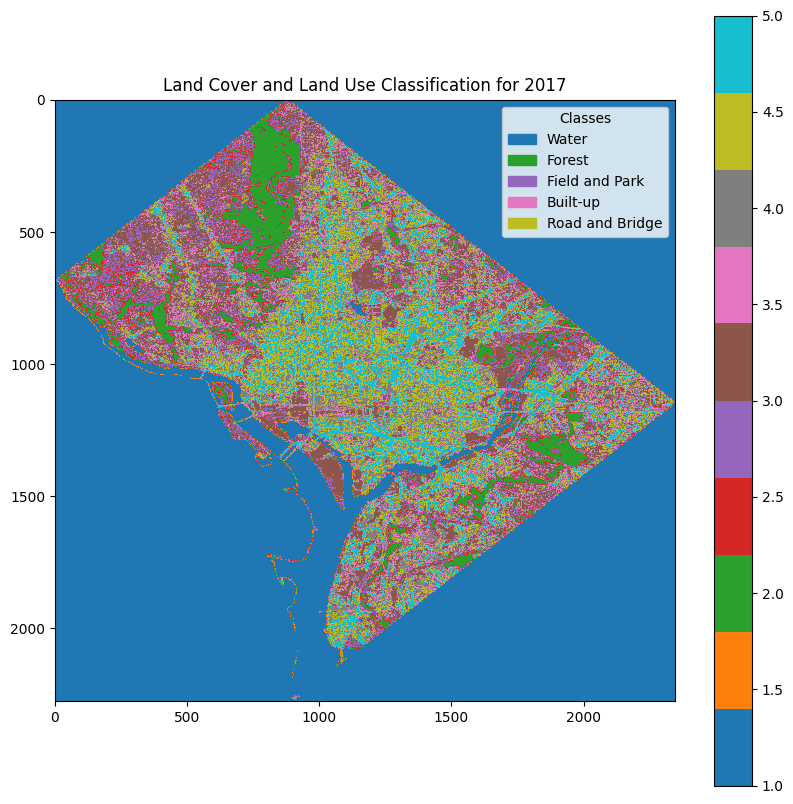

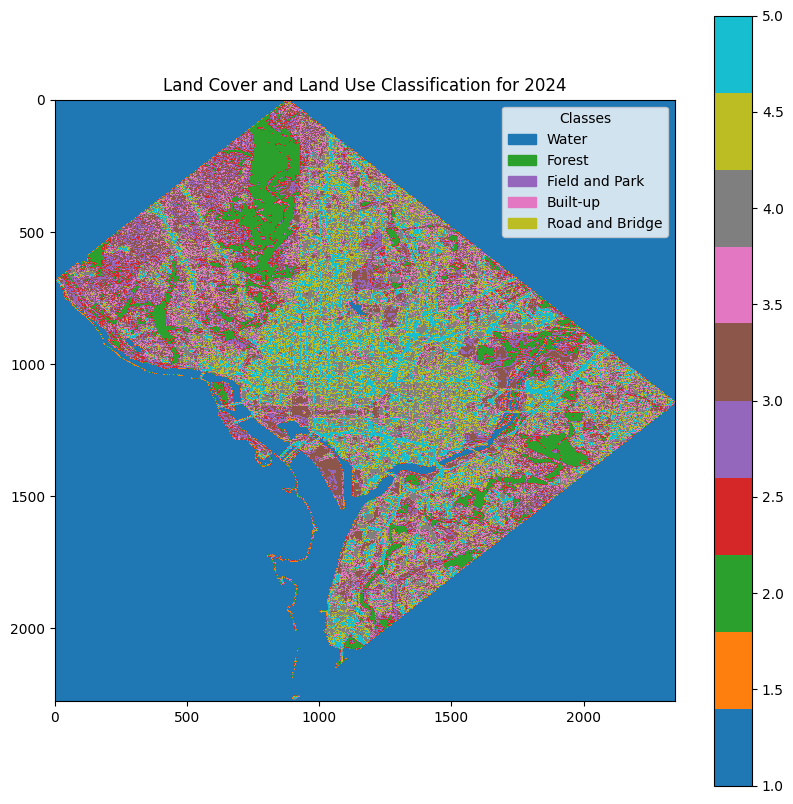

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define the class labels and corresponding colors in the colormap
class_labels = ['Water', 'Forest', 'Field and Park', 'Built-up', 'Road and Bridge']
colormap = plt.cm.tab10

# Create a custom legend
legend_handles = [mpatches.Patch(color=colormap(i / len(class_labels)), label=class_labels[i]) for i in range(len(class_labels))]

# Visualize the classification result for 2017
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2017")
plt.imshow(y_pred_2017_img, cmap='tab10')
plt.colorbar()
plt.legend(handles=legend_handles, loc='upper right', title='Classes')
plt.show()

# Visualize the classification result for 2024
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2024")
plt.imshow(y_pred_2024_img, cmap='tab10')
plt.colorbar()
plt.legend(handles=legend_handles, loc='upper right', title='Classes')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define the class labels and corresponding colors in the colormap
class_labels = ['Water', 'Forest', 'Field and Park', 'Built-up', 'Road and Bridge']
colormap = plt.cm.tab10

# Create a custom legend
legend_handles = [mpatches.Patch(color=colormap(i / len(class_labels)), label=class_labels[i]) for i in range(len(class_labels))]

# Visualize the classification result for 2017
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2017")
plt.imshow(y_pred_2017_img, cmap='tab10')
plt.colorbar()
plt.legend(handles=legend_handles, loc='upper right', title='Classes')
plt.show()

# Visualize the classification result for 2024
plt.figure(figsize=(10, 10))
plt.title("Land Cover and Land Use Classification for 2024")
plt.imshow(y_pred_2024_img, cmap='tab10')
plt.colorbar()
plt.legend(handles=legend_handles, loc='upper right', title='Classes')
plt.show()

In [66]:
pred_2017 = y_pred_2017_img
pred_2024 = y_pred_2024_img

# Ensure the dimensions of both predictions match
assert pred_2017.shape == pred_2024.shape, "The dimensions of the classification maps do not match."

# Define the number of classes correctly (assuming 5 classes: 1 to 5)
num_classes = 5

# Correctly encode the detailed change map
detailed_change_map = num_classes * (pred_2017 - 1) + (pred_2024 - 1)


# Optional: Create a human-readable change description map
change_descriptions = {
    0: "No Change",
    1: "Water to Forest",
    2: "Water to Field and Park",
    3: "Water to Build-up",
    4: "Water to Road and Bridge",
    5: "Forest to Water",
    6: "No Change", # Forest to Forest
    7: "Forest to Field and Park",
    8: "Forest to Build-up",
    9: "Forest to Road and Bridge",
    10: "Field and Park to Water",
    11: "Field and Park to Forest",
    12: "No Change", # Field and Park to Field and Park
    13: "Field and Park to Build-up",
    14: "Field and Park to Road and Bridge",
    15: "Build-up to Water",
    16: "Build-up to Forest",
    17: "Build-up to Field and Park",
    18: "No Change", # Build-up to Build-up
    19: "Build-up to Road and Bridge",
    20: "Road and Bridge to Water",
    21: "Road and Bridge to Forest",
    22: "Road and Bridge to Field and Park",
    23: "Road and Bridge to Build-up",
    24: "No Change"  # Road and Bridge to Road and Bridge
}

# Create a human-readable map using change_descriptions
change_description_map = np.vectorize(change_descriptions.get)(detailed_change_map)



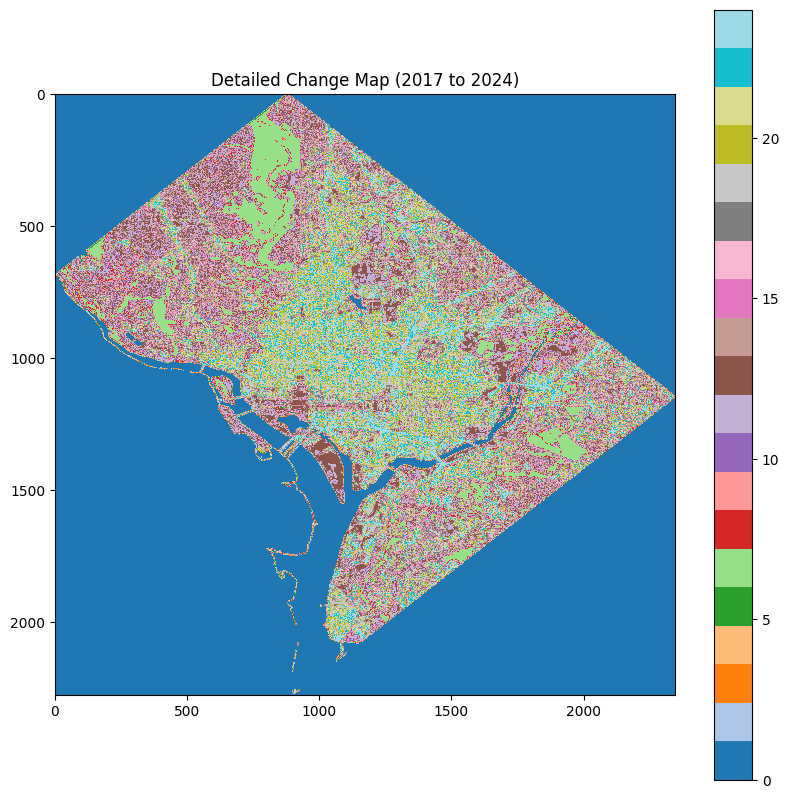

In [67]:
import matplotlib.pyplot as plt

# Visualize the detailed change map
plt.figure(figsize=(10, 10))
plt.imshow(detailed_change_map, cmap='tab20')
plt.title('Detailed Change Map (2017 to 2024)')
plt.colorbar()
plt.show()

<ipython-input-13-58fad4342c19>:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20c', len(change_descriptions))


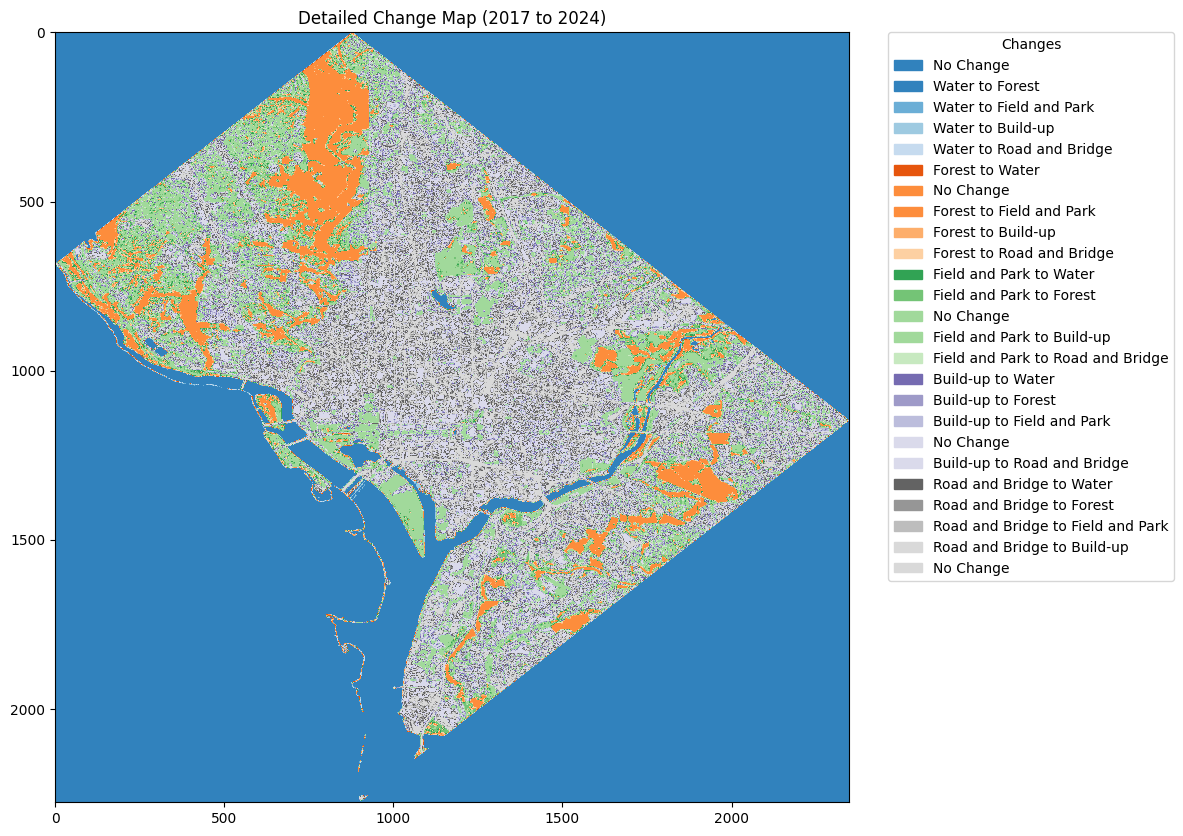

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Your previous code
pred_2017 = y_pred_2017_img
pred_2024 = y_pred_2024_img

# Ensure the dimensions of both predictions match
assert pred_2017.shape == pred_2024.shape, "The dimensions of the classification maps do not match."

# Define the number of classes correctly (assuming 5 classes: 1 to 5)
num_classes = 5

# Correctly encode the detailed change map
detailed_change_map = num_classes * (pred_2017 - 1) + (pred_2024 - 1)

# Optional: Create a human-readable change description map
change_descriptions = {
    0: "No Change",
    1: "Water to Forest",
    2: "Water to Field and Park",
    3: "Water to Build-up",
    4: "Water to Road and Bridge",
    5: "Forest to Water",
    6: "No Change", # Forest to Forest
    7: "Forest to Field and Park",
    8: "Forest to Build-up",
    9: "Forest to Road and Bridge",
    10: "Field and Park to Water",
    11: "Field and Park to Forest",
    12: "No Change", # Field and Park to Field and Park
    13: "Field and Park to Build-up",
    14: "Field and Park to Road and Bridge",
    15: "Build-up to Water",
    16: "Build-up to Forest",
    17: "Build-up to Field and Park",
    18: "No Change", # Build-up to Build-up
    19: "Build-up to Road and Bridge",
    20: "Road and Bridge to Water",
    21: "Road and Bridge to Forest",
    22: "Road and Bridge to Field and Park",
    23: "Road and Bridge to Build-up",
    24: "No Change"  # Road and Bridge to Road and Bridge
}

# Create a human-readable map using change_descriptions
change_description_map = np.vectorize(change_descriptions.get)(detailed_change_map)

# Define the colormap
colormap = plt.cm.get_cmap('tab20c', len(change_descriptions))

# Create a custom legend
legend_handles = [mpatches.Patch(color=colormap(i / len(change_descriptions)), label=change_descriptions[i]) for i in range(len(change_descriptions))]

# Visualize the detailed change map
plt.figure(figsize=(12, 10))
plt.imshow(detailed_change_map, cmap=colormap)
plt.title('Detailed Change Map (2017 to 2024)')
#plt.colorbar()

# Position the legend outside of the plot
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Changes')

plt.show()


<ipython-input-22-ed20a50255c9>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20c', len(change_descriptions))


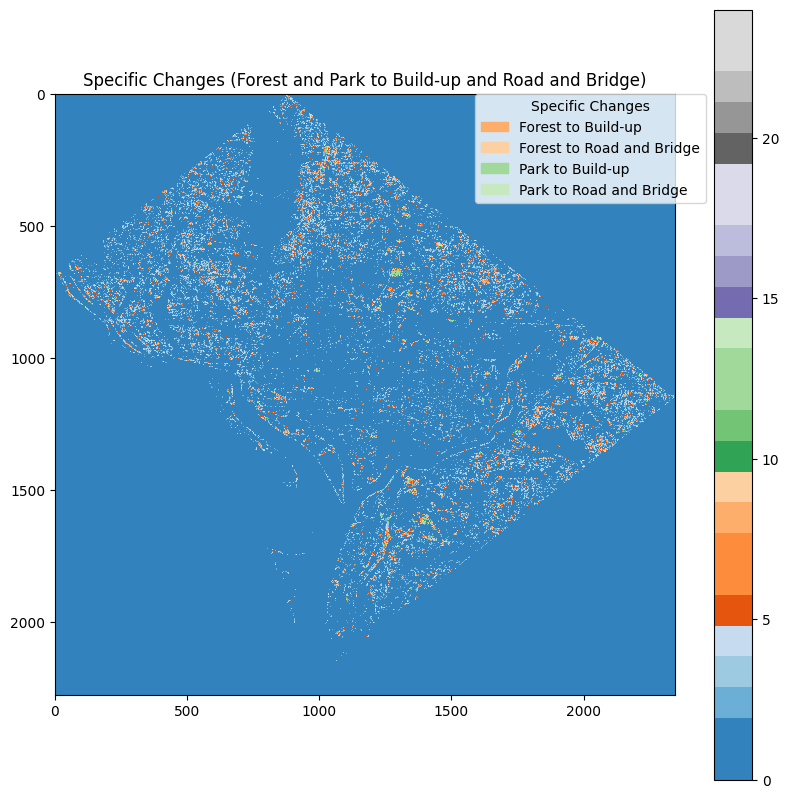

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define the specific transition codes
forest_to_build_up = num_classes * (2 - 1) + (4 - 1)  # Forest (2) to Build-up (4)
forest_to_road_bridge = num_classes * (2 - 1) + (5 - 1)  # Forest (2) to Road and Bridge (5)
park_to_build_up = num_classes * (3 - 1) + (4 - 1)  # Park (3) to Build-up (4)
park_to_road_bridge = num_classes * (3 - 1) + (5 - 1)  # Park (3) to Road and Bridge (5)

# Create a mask for these specific transitions
specific_changes_mask = (
    (detailed_change_map == forest_to_build_up) |
    (detailed_change_map == forest_to_road_bridge) |
    (detailed_change_map == park_to_build_up) |
    (detailed_change_map == park_to_road_bridge)
)

# Extract the specific transitions and set all other values to zero
specific_changes = np.where(specific_changes_mask, detailed_change_map, 0)

# Define the colormap
colormap = plt.cm.get_cmap('tab20c', len(change_descriptions))

# Create a custom legend
legend_handles = [
    mpatches.Patch(color=colormap(forest_to_build_up / len(change_descriptions)), label='Forest to Build-up'),
    mpatches.Patch(color=colormap(forest_to_road_bridge / len(change_descriptions)), label='Forest to Road and Bridge'),
    mpatches.Patch(color=colormap(park_to_build_up / len(change_descriptions)), label='Park to Build-up'),
    mpatches.Patch(color=colormap(park_to_road_bridge / len(change_descriptions)), label='Park to Road and Bridge')
]

# Visualize the specific changes
plt.figure(figsize=(10, 10))
plt.imshow(specific_changes, cmap=colormap, vmin=0, vmax=num_classes**2-1)
plt.title('Specific Changes (Forest and Park to Build-up and Road and Bridge)')
plt.colorbar()
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0., title='Specific Changes')
plt.show()
